In [1]:
import os
import sys

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import scipy
import altair as alt
from altair import datum

%run constants.py

%matplotlib inline
print("Versions:")
print("  Python: %s" % sys.version)
for module in [pd, np, sns, sklearn, alt]:
    print("  %s: %s" %(module.__name__, module.__version__))

Versions:
  Python: 3.8.2 (default, Jul 16 2020, 14:00:26) 
[GCC 9.3.0]
  pandas: 1.1.0
  numpy: 1.19.1
  seaborn: 0.10.1
  sklearn: 0.23.2
  altair: 4.1.0


# EDA

The goal on this notebook is to gain more knowledge and insight on the data we are dealing. From this we can start thinking of features we can implement. Let's start by loading our CSV files and generating the sales by month.

In [2]:
# load all csvs
import zipfile
with zipfile.ZipFile(os.path.join(DATASETS_DIR, 'competitive-data-science-predict-future-sales.zip'), 'r') as datasets_file:
    item_categories = pd.read_csv(datasets_file.open('item_categories.csv'))
    items = pd.read_csv(datasets_file.open('items.csv'))
    sales_train = pd.read_csv(datasets_file.open('sales_train.csv'))
    sample_submission = pd.read_csv(datasets_file.open('sample_submission.csv'))
    shops = pd.read_csv(datasets_file.open('shops.csv'))
    test_set = pd.read_csv(datasets_file.open('test.csv'))
sales_train = sales_train[~((sales_train['shop_id'] < 2) | (sales_train['item_id'] < 30) | (sales_train['item_id'] > 22167))]
sales_train_by_month = sales_train.groupby(by=['date_block_num', 'shop_id', 'item_id'])['item_cnt_day'].sum().reset_index().rename(columns={'item_cnt_day': 'item_cnt_month'})

Here I'll split the features I want to analyze into two parts: time series data and metadata. Time series is more related to how things change over time, while metadata is more about what information we have encoded that's available for each item/shop pair in an instant.

Because metadata can change over time and these changes can be meaningful, I will start analyzing the meta data we have available. The first thing I want to look into is the item categories, so let's see the shape of this data.

## Item category metadata

In [3]:
item_categories.describe()

,item_category_id
count,84.000000
mean,41.500000
std,24.392622
min,0.000000
25%,20.750000
50%,41.500000
75%,62.250000
max,83.000000


In [4]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


We can see the category name carries some useful info. By translating them, we can see the first lines are accessories for gaming consoles and PCs (headsets and headphones in the PC case). We should be able to extract some interesting things from here. Let's check if the pattern is consistent by splitting everything on the dash (`-`).

In [5]:
split_category_names = item_categories['item_category_name'].str.split(pat='-', expand=True)
split_category_names

,0,1,2
0,PC,Гарнитуры/Наушники,None
1,Аксессуары,PS2,None
2,Аксессуары,PS3,None
3,Аксессуары,PS4,None
4,Аксессуары,PSP,None
...,...,...,...
79,Служебные,None,None
80,Служебные,Билеты,None
81,Чистые носители (шпиль),None,None
82,Чистые носители (штучные),None,None


In [6]:
split_category_names.describe()

,0,1,2
count,84,77,3
unique,21,58,3
top,Книги,Цифра,Ray 4K
freq,13,4,1


We can see most of them have at least one dash and the first element is the one that varies the least. Let's check the examples that are split three times, which seem to be the rarest.

In [7]:
split_category_names[~split_category_names[2].isna()]

,0,1,2
37,Кино,Blu,Ray
38,Кино,Blu,Ray 3D
39,Кино,Blu,Ray 4K


All of them are different "blu ray" types, so we can just join the last column. Let's now look at the examples that have no dashes.

In [8]:
split_category_names[split_category_names[1].isna()]

,0,1,2
8,Билеты (Цифра),None,None
9,Доставка товара,None,None
32,"Карты оплаты (Кино, Музыка, Игры)",None,None
79,Служебные,None,None
81,Чистые носители (шпиль),None,None
82,Чистые носители (штучные),None,None
83,Элементы питания,None,None


Let's translate them so we can understand it better. From google translate, we got:
- Tickets (Number)
- Delivery of goods
- Payment cards (Cinema, Music, Games)
- Service
- Blank media (spire)
- Blank media (piece)
- Batteries

Which seem quite random. We'll call them "other" and group them in a single category.

We can now call the first column the major category and the second column a subcategory, from the frequencies we observed.

In [9]:
item_categories2 = item_categories['item_category_name'].str.split(pat='-', expand=True, n=1).rename(columns={0: "category_name", 1: "subcategory_name"})
item_categories2['item_category_id'] = item_categories['item_category_id'] 
item_categories2

,category_name,subcategory_name,item_category_id
0,PC,Гарнитуры/Наушники,0
1,Аксессуары,PS2,1
2,Аксессуары,PS3,2
3,Аксессуары,PS4,3
4,Аксессуары,PSP,4
...,...,...,...
79,Служебные,None,79
80,Служебные,Билеты,80
81,Чистые носители (шпиль),None,81
82,Чистые носители (штучные),None,82


In [10]:
tmp_filter = item_categories2['subcategory_name'].isna()
item_categories2.loc[tmp_filter, 'subcategory_name'] =  item_categories2.loc[tmp_filter, 'category_name']
item_categories2.loc[tmp_filter, 'category_name'] = 'Other'

In [11]:
item_categories2.describe(include='all')

,category_name,subcategory_name,item_category_id
count,84,84,84.000000
unique,15,67,NaN
top,Книги,Цифра,NaN
freq,13,4,NaN
mean,NaN,NaN,41.500000
std,NaN,NaN,24.392622
min,NaN,NaN,0.000000
25%,NaN,NaN,20.750000
50%,NaN,NaN,41.500000
75%,NaN,NaN,62.250000


Now let's check the relationship with the training set. Let's merge the datasets and then plot some 2D histograms to see what we find.

In [20]:
item_categories_metadata = items[['item_id', 'item_category_id']] # table with relationship between item and category
item_categories_metadata = item_categories_metadata.merge(item_categories2, on='item_category_id')
item_categories_metadata.describe()

,item_id,item_category_id
count,22170.00000,22170.000000
mean,11084.50000,46.290753
std,6400.07207,15.941486
min,0.00000,0.000000
25%,5542.25000,37.000000
50%,11084.50000,40.000000
75%,16626.75000,58.000000
max,22169.00000,83.000000


In [22]:
df = sales_train_by_month[sales_train_by_month['date_block_num'] == sales_train_by_month['date_block_num'].max()]
df_train = df.merge(item_categories_metadata, on='item_id')
df_test = test_set.merge(item_categories_metadata, on='item_id')

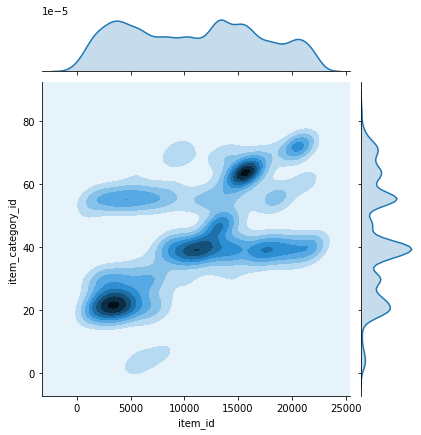

In [31]:
sns.jointplot(data=df_train, x='item_id', y='item_category_id', kind='kde')

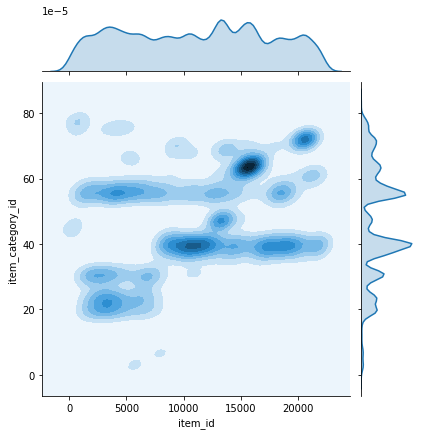

In [32]:
sns.jointplot(data=df_test, x='item_id', y='item_category_id', kind='kde')

They look similar. It's interesting to see that some categories appear a lot more than others. Let's plot the distribution for sales now.

<AxesSubplot:xlabel='item_category_id'>

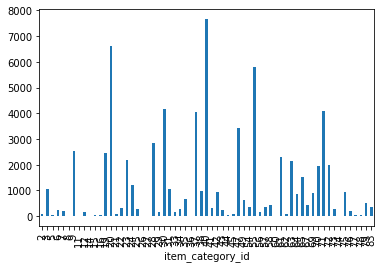

In [40]:
df_train.groupby(by='item_category_id')['item_cnt_month'].sum().plot.bar()

<AxesSubplot:xlabel='category_name'>

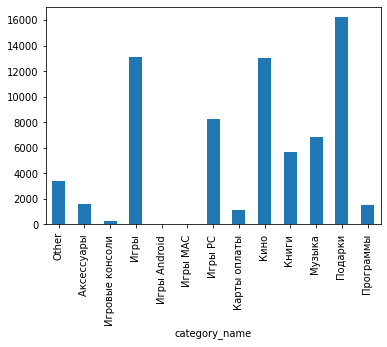

In [43]:
df_train.groupby(by='category_name')['item_cnt_month'].sum().plot.bar()

<AxesSubplot:xlabel='subcategory_name'>

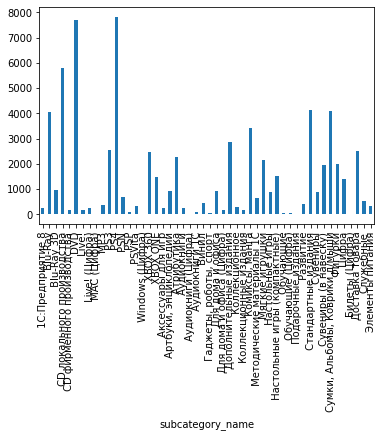

In [44]:
df_train.groupby(by='subcategory_name')['item_cnt_month'].sum().plot.bar()

We can encode these categories and subcategories and use them on our models.